In [1]:
import pandas as pd
import numpy as np
import lifelines as ll
import sksurv as sks
import matplotlib.pyplot as plt
from bart_survival import surv_bart as sb
from bart_survival import simulation as sm
import lifelines as ll
from lifelines import KaplanMeierFitter
import subprocess

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from _functions1 import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Functions

## Simulation Functions

2 cens
3 smpl
5 times
== 30 total scenarios

In [2]:
rng = np.random.default_rng(99)

There is no good way to predetermine censoring. Lower cens_scale == > cens percent. 4 is generally around 20%, .5 generally around 50% censored.
Trial to find

In [2]:
# cns = []
# for i in range(0,1000):
#     event_dict, sv_true, sv_scale_true = sm.simulate_survival(
#         x_mat = x_mat,
#         scale_f="2.5*x_mat[:,0]",
#         shape_f=".8",
#         cens_scale=3.3,
#         rng = rng
#     )
#     # print(event_dict["cens_percentage"])
#     cns.append(event_dict["status"][event_dict["status"]==0].shape[0]/event_dict["status"].shape[0])

In [3]:
def get_sim(rng, N, type, x_vars, VAR_CLASS, VAR_PROB, scale_f, shape_f, cens_scale):
    x_mat = sm.get_x_matrix(
        N = N,
        x_vars = x_vars, 
        VAR_CLASS=VAR_CLASS,
        VAR_PROB= VAR_PROB
    )

    event_dict, sv_true, sv_scale_true = sm.simulate_survival(
        x_mat = x_mat,
        scale_f=scale_f,
        shape_f=shape_f,
        cens_scale=cens_scale,
        rng = rng
    )
    return type, x_mat, event_dict, sv_true, sv_scale_true

In [4]:
#simple
N = [100, 200,400]

simple_1_1 = {
    "type": "Simple, 1 group, 50% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[1],
    "scale_f": "2.5*x_mat[:,0]",
    "shape_f": ".8",
    "cens_scale":3.3,
}
simple_1_2 = {
    "type": "Simple, 1 group, 50% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[1],
    "scale_f": "2.5*x_mat[:,0]",
    "shape_f": ".8",
    "cens_scale":.5,
}

simple_2_1 = {
    "type": "Simple, 2 group, 50% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[.5],
    "scale_f": "2.5 + 1.05*x_mat[:,0]",
    "shape_f": ".8 + .5*x_mat[:,0]",
    "cens_scale":3
}

simple_2_2 = {
    "type": "Simple, 2 group, 50% cens",
    "x_vars": 1, 
    "VAR_CLASS": [2],
    "VAR_PROB":[.5],
    "scale_f": "2.5 + 1.05*x_mat[:,0]",
    "shape_f": ".8 + .5*x_mat[:,0]",
    "cens_scale":.7
}


In [6]:
# type, x_mat, event_dict, sv_true, sv_scale_true = get_sim(rng, N[0], **simple_2_1)

mean shape 1.07
mean scale 3.0669999999999997
mean time draws 2.706501909533985
cens mean 10.5


In [5]:
def confirm_cens_perc(event_dict):
    return (event_dict["status"]==0).sum()/(event_dict["status"].shape[0])

def check_x_mat_ones(x_mat):
    assert np.all(x_mat[:,0] == 1)

def get_max_time(event_dict):
    return event_dict["t_event"].max()

def exp_diff_actual(sv_true, msk):
    return sv_true["sv_true"][msk] - sv_true["sv_true"][~msk]

def expand_kpm_ci(k1_ci, k1):
    uq = np.unique(k1, return_counts=True, return_index=True)
    up = k1_ci.values[:,1].reshape(-1)
    lw = k1_ci.values[:,0].reshape(-1)
    long_upper_ci = np.zeros_like(k1)
    long_lower_ci = np.zeros_like(k1)
    for i in range(uq[1].shape[0]):
        uniq_idx = uq[1][i]
        repeats = uq[2][i]
        lw_tmp = np.repeat(lw[uniq_idx], repeats)
        up_tmp = np.repeat(up[uniq_idx], repeats)
        long_idx = np.arange(uniq_idx, uniq_idx+repeats)
        long_upper_ci[long_idx] = up_tmp
        long_lower_ci[long_idx] = lw_tmp
    return np.hstack([long_upper_ci.reshape(-1,1), long_lower_ci.reshape(-1,1)])

def onepop_kpm(event_dict):
    kpm = ll.KaplanMeierFitter()
    kpm.fit(durations=event_dict["t_event"], event_observed=event_dict["status"])
    # ttt = np.arange(t_max)
    k1 = kpm.survival_function_.values
    # k1 = kpm.survival_function_at_times(ttt).to_numpy()
    k1_ci = kpm.confidence_interval_survival_function_.values
    # k1_ci = expand_kpm_ci(k1_ci, k1)
    return k1[1:,0], k1_ci[1:,:].T

def save_to_csv(event_dict, x_mat):
    col = ["t","s"] + ["x"+str(i) for i in range(x_mat.shape[1])]
    df = pd.DataFrame(np.hstack(
        [
            event_dict["t_event"],
            event_dict["status"],
            x_mat
        ]
    ),columns= col)
    exp_name = "exp1_tmp.csv"
    path = f"../data/{exp_name}"
    df.to_csv(path,index = False)
    

In [6]:
def get_py_bart_surv(x_mat, event_dict, model_dict, sampler_dict):
    y_sk = sb.get_y_sklearn(status = event_dict["status"], t_event=event_dict["t_event"])
    trn = sb.get_surv_pre_train(y_sk = y_sk, x_sk = x_mat, weight=None)
    post_test = sb.get_posterior_test(y_sk = y_sk, x_test = x_mat)
    small_post_x = np.unique(post_test["post_x"][:,0]).reshape(-1,1)
    small_coords = np.hstack([np.repeat(0, small_post_x.shape[0]), np.repeat(1, small_post_x.shape[0]), ])
    small_post_x = np.vstack([small_post_x, small_post_x])
    # assert False

    BSM = sb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)
    # fit with just the time column
    BSM.fit(y=trn["y"], X=trn["x"][:,0].reshape(-1,1), weights=trn["w"], coords = trn["coord"], random_seed=99)
    # test with just the time column
    # post1 = BSM.sample_posterior_predictive(X_pred=post_test["post_x"][:,0].reshape(-1,1), coords=post_test["coords"])
    post1 = BSM.sample_posterior_predictive(X_pred=small_post_x, coords=small_coords)
    sv_prob = sb.get_sv_prob(post1)
    sv_m = sv_prob["sv"].mean(1).mean(0)
    uniq_t = BSM.uniq_times
    sv_q = np.quantile(sv_prob["sv"].mean(1), [0.025,0.975], axis=0)
    return sv_m, sv_q, uniq_t, sv_prob

def get_r_bart(event_dict, x_mat):
    save_to_csv(event_dict, x_mat)
    subprocess.call("/usr/bin/Rscript --vanilla ../R/bart_1.R", shell=True)
    r_sv = pd.read_csv("../data/exp1_tmp_out2.csv").values
    r_sv_m = r_sv[:,0].T
    r_sv_q = r_sv[:,1:].T
    return r_sv_m, r_sv_q

In [7]:
def get_quant_times(uniq_t, uniq=True):
    """gets the index of quantile values

    Args:
        uniq_t (array): Unique values of observed times
        uniq (bool, optional): Indicator returns just the unique quantiles if values repeat. Defaults to True.

    Returns:
        nd.array: Array of indexes of the quantiles.
    """
    qnt_t = np.quantile(uniq_t, [.1, .25, .5, .75, .9], method = "closest_observation")
    qnt_idx = np.array([(np.abs(uniq_t-i).argmin()) for i in qnt_t])
    if uniq:
        qnt_t = np.unique(qnt_t)
        qnt_idx=np.unique(qnt_idx)


    return qnt_t.astype("int"), qnt_idx.astype("int")
# pb_uniq_t

def coverage(sv_true, tst_ci, qnt_t, qnt_idx):
    ci_lst = []
    sv_true = sv_true[qnt_t]
    tst_ci = tst_ci[:,qnt_idx]
    for i in range(sv_true.shape[0]):
        in_ci = tst_ci[0,i] <= sv_true[i] <= tst_ci[1,i]
        # in_ci = sv_true[i] >= tst_ci[0,i] and sv_true[i] <= tst_ci[1,i]
        ci_lst.append(in_ci)
    return np.array(ci_lst)


In [28]:
def rmse_single(sv_true, tst_m, qnt_t, qnt_idx):
    rmse = np.sqrt(np.power(sv_true[qnt_t] - tst_m[qnt_idx],2))
    return rmse

def bias_single(sv_true, tst_m, qnt_t, qnt_idx):
    bias = sv_true[qnt_t] - tst_m[qnt_idx]
    return bias

def ci_length(tst_q, qnt_idx):
    ci_l = tst_q[1,qnt_idx]-tst_q[0,qnt_idx]
    return ci_l

In [72]:

# iterate Z times
def sim_1s(seed, n, scenario, SPLIT_RULES, model_dict, sampler_dict):
    # set rng as seed given
    if type(seed) is int:
        rng = np.random.default_rng(seed)
    else:
        rng = seed
    # generate survival simulation
    scenario, x_mat, event_dict, sv_true, sv_scale_true = get_sim(rng, n, **scenario)
    # type, x_mat, event_dict, sv_true, sv_scale_true = get_sim(rng, N[0], **simple_1_2)
    cens_perc = event_dict["status"][event_dict["status"] == 0].shape[0]/event_dict["status"].shape[0]
    # get uniq times and quantiles as indexes
    uniq_t = np.unique(event_dict["t_event"]) 
    qnt_t, qnt_idx = get_quant_times(uniq_t, uniq = False)
    # singular sv true
    sv_true_r1 = sv_true["sv_true"][0,:]
    # check x_mat
    check_x_mat_ones(x_mat)
    # fit kpm
    k_sv_m, k_sv_q = onepop_kpm(event_dict)
    # fit bart_py
    pb_sv_m, pb_sv_q, pb_uniq_t, sv_prob = get_py_bart_surv(x_mat=x_mat, event_dict=event_dict, model_dict=model_dict, sampler_dict=sampler_dict)
    # fit bart_r
    r_sv_m, r_sv_q = get_r_bart(event_dict, x_mat)
    return sv_true, cens_perc, uniq_t, qnt_t, qnt_idx, sv_true_r1, k_sv_m, k_sv_q, pb_sv_m, pb_sv_q, r_sv_m, r_sv_q

def get_metrics(
    sv_true_r1,
    qnt_t, qnt_idx,
    k_sv_m, k_sv_q,
    pb_sv_m, pb_sv_q,
    r_sv_m, r_sv_q
):
    # coverage probability 
    k_cov = coverage(sv_true_r1, k_sv_q, qnt_t-1, qnt_idx)
    pb_cov = coverage(sv_true_r1, pb_sv_q, qnt_t-1, qnt_idx)
    r_cov = coverage(sv_true_r1, r_sv_q, qnt_t-1, qnt_idx)
    # interval length
    k_ci_l = ci_length(k_sv_q, qnt_idx)
    pb_ci_l = ci_length(pb_sv_q, qnt_idx)
    r_ci_l = ci_length(r_sv_q, qnt_idx)

    #RMSE
    k_rmse = rmse_single(sv_true_r1, k_sv_m, qnt_t-1, qnt_idx)
    pb_rmse = rmse_single(sv_true_r1, pb_sv_m, qnt_t-1, qnt_idx)
    r_rmse = rmse_single(sv_true_r1, r_sv_m, qnt_t-1, qnt_idx)
    # bias
    k_bias = bias_single(sv_true_r1, k_sv_m, qnt_t-1, qnt_idx)
    pb_bias = bias_single(sv_true_r1, pb_sv_m, qnt_t-1, qnt_idx)
    r_bias = bias_single(sv_true_r1, r_sv_m, qnt_t-1, qnt_idx)
    return k_cov, pb_cov, r_cov, k_ci_l, pb_ci_l, r_ci_l, k_rmse, pb_rmse, r_rmse, k_bias, pb_bias, r_bias


In [137]:
SPLIT_RULES =  [
    "pmb.ContinuousSplitRule()", 
    # "pmb.OneHotSplitRule()"
]
model_dict = {"trees": 10,
    "split_rules": SPLIT_RULES
}
sampler_dict = {
            "draws": 200,
            "tune": 30,
            "cores": 6,
            "chains": 6,
            "compute_convergence_checks": False
        }

In [1]:
# i_lst = []
# sv_true_r1_lst = [] 
# cens_perc_lst = []
# uniq_t_lst = []
# qnt_t_lst = []

# k_cov_lst = []
# pb_cov_lst = []
# r_cov_lst = []
# k_ci_l_lst = []
# pb_ci_l_lst = []
# r_ci_l_lst = []
# k_rmse_lst = []
# pb_rmse_lst = []
# r_rmse_lst = []
# k_bias_lst = [] 
# pb_bias_lst = []
# r_bias_lst = []

# for i in range(1):
#     print(i)
#     i_lst.append(i)
#     sv_true, cens_perc, uniq_t, qnt_t, qnt_idx, sv_true_r1, k_sv_m, k_sv_q, pb_sv_m, pb_sv_q, r_sv_m, r_sv_q = sim_1s(seed=i, n=N[0], scenario=simple_1_1, SPLIT_RULES=SPLIT_RULES, model_dict=model_dict, sampler_dict=sampler_dict)
#     cens_perc_lst.append(cens_perc)
#     uniq_t_lst.append(uniq_t)
#     qnt_t_lst.append(qnt_t)

#     k_cov, pb_cov, r_cov, k_ci_l, pb_ci_l, r_ci_l, k_rmse, pb_rmse, r_rmse, k_bias, pb_bias, r_bias = get_metrics(
#         sv_true_r1,
#         qnt_t, qnt_idx,
#         k_sv_m, k_sv_q,
#         pb_sv_m, pb_sv_q,
#         r_sv_m, r_sv_q
#     )
#     k_cov_lst.append(k_cov)
#     pb_cov_lst.append(pb_cov)
#     r_cov_lst.append(r_cov)
#     k_ci_l_lst.append(k_ci_l)
#     pb_ci_l_lst.append(pb_ci_l)
#     r_ci_l_lst.append(r_ci_l)
#     k_rmse_lst.append(k_rmse)
#     pb_rmse_lst.append(pb_rmse)
#     r_rmse_lst.append(r_rmse)
#     k_bias_lst.append(k_bias)
#     pb_bias_lst.append(pb_bias)
#     r_bias_lst.append(r_bias)
    

In [145]:
print(np.array(k_ci_l_lst).mean(0))
print(np.array(pb_ci_l_lst).mean(0))
print(np.array(r_ci_l_lst).mean(0))


[0.18883315 0.19374718 0.16994323 0.14269829 0.12422939]
[0.17410374 0.17658999 0.14637976 0.10976133 0.08637622]
[0.18403567 0.1896887  0.16236159 0.12458268 0.09441894]


In [141]:



print(np.array(k_cov_lst).sum(0)/100)
print(np.array(pb_cov_lst).sum(0)/100)
print(np.array(r_cov_lst).sum(0)/100)

# np.array(qnt_t_lst).mean(0)
print(np.array(cens_perc_lst).shape)
# print(np.array(pb_rmse_lst).mean(0))
# print(np.array(r_rmse_lst).mean(0))

0.13864220949816183
[0.97 0.95 0.98 0.96 0.97]
[0.9  0.93 0.94 0.92 0.92]
[0.98 0.97 0.97 0.94 0.94]


(100,)

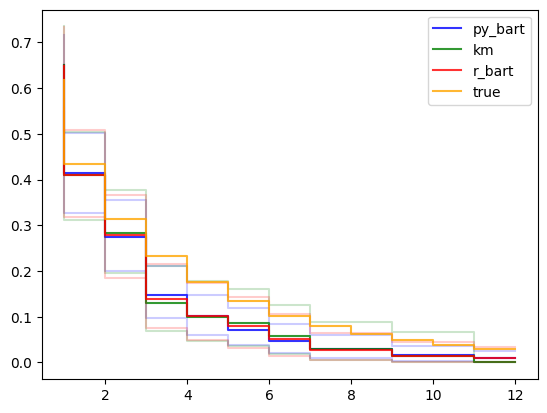

In [91]:

# ttt = np.arange(1, svv.shape[0]+1)
ttt = uniq_t
plt.step(ttt,pb_sv_m, color = "blue", alpha=0.8, label = "py_bart")
plt.step(ttt, pb_sv_q[0,:], color="blue", alpha=0.2,)
plt.step(ttt, pb_sv_q[1,:], color="blue", alpha=0.2)
plt.step(ttt, k_sv_m, color="green", alpha=0.8, label="km")
plt.step(ttt, k_sv_q[0,:], color="green", alpha=0.2)
plt.step(ttt, k_sv_q[1,:], color="green", alpha=0.2)
plt.step(ttt, r_sv_m, color = "red", alpha=0.8, label="r_bart")
plt.step(ttt, r_sv_q[0,:], color = "red", alpha=0.2)
plt.step(ttt, r_sv_q[1,:], color = "red", alpha=0.2)

plt.step(sv_true["true_times"], sv_true["sv_true"].mean(0), color = "orange", alpha=0.8, label="true")
plt.legend()
